In [66]:
# Perform polarization analysis of the signals of one hammer shot

In [67]:
## Import modules
from obspy import read, UTCDateTime, Stream
from utils_pol import get_pol_vidale, plot_waveforms_and_pols, get_p_dip, get_psv_strike, plot_station_strike_and_dip
from utils_snuffler import read_phase_markers
from utils_preproc import preprocess_stream
from pandas import read_csv, to_datetime, DataFrame
from numpy import linspace, interp
from os.path import join

In [68]:
## Inputs
root = "/Volumes/OmanData/geophones_no_prefilt/data"
timewin = "2020-01-25-10-00-00"
hammer = "Hammer10-00-15"

winlen_pol = 7 # Window length for estimating the polarization parameters (in points)
winlen_dip = 10 # Window length for estimating the dip angle of P particle motion (in points)
winlen_strike = 20 # Window length for estimating the strike angle of P and S particle motions (in points)
interp_factor = None

begin = -0.02
end = 0.2

freqmin = None
freqmax = 450

mapbound = "map_boundary_A.csv"


In [69]:
## Read the P picks
inpath = join(root, timewin, f"ppicks_{hammer}.dat")
pickdf = read_phase_markers(inpath)

In [70]:
## Read the source information
inpath = join(root, timewin, f"location_{hammer}_P.csv")
sourcedf = read_csv(inpath, delimiter=" ", parse_dates=["origin_time"])

In [71]:
## Read the station information
inpath = join(root, "stations.csv")
stadf = read_csv(inpath, delimiter=" ", index_col=0)

In [72]:
## Read the map boundary
inpath = join(root, mapbound)
mapdf = read_csv(inpath, delimiter=" ")

In [73]:
## Read and preprocess the waveforms
stream = Stream()
for i, row in pickdf.iterrows():
    station  = row["station"]
    ptime = UTCDateTime(row["time"])
    starttime = ptime + begin
    endtime = ptime + end

    stream += read(join(root, timewin, f"*{station}*SAC"), starttime=starttime, endtime=endtime)

stream = preprocess_stream(stream, freqmin=freqmin, freqmax=freqmax)

In [74]:
## Get the polarizations at each station
plotdicts = []
for station in pickdf["station"]:
    print(f"Processing Station, {station}...")

    trace_e = stream.select(station=station, channel="*2")[0]
    trace_n = stream.select(station=station, channel="*1")[0]
    trace_z = stream.select(station=station, channel="*Z")[0]

    data_e = trace_e.data
    data_n = trace_n.data
    data_z = trace_z.data

    timeax = stream[0].times()+begin
    sampint = trace_e.stats.delta

    ### Upsample the waveforms
    if interp_factor is not None:
        timeax_interp = linspace(timeax[0], timeax[-1], len(timeax)*interp_factor)

        data_interp_e = interp(timeax_interp, timeax, data_e)
        data_interp_n = interp(timeax_interp, timeax, data_n)
        data_interp_z = interp(timeax_interp, timeax, data_z)

        data_e = data_interp_e
        data_n = data_interp_n
        data_z = data_interp_z
        timeax = timeax_interp

    ### Get the polarization parameters
    pol_params = get_pol_vidale(data_e, data_n, data_z, winlen=winlen_pol)

    ### Plot the waveforms and polarizations
    fig, axdict, timeax_pol = plot_waveforms_and_pols(data_e, data_n, data_z, pol_params, timeax, winlen=winlen_pol, station=station, ampmax=0.2)

    ### Get the dip angle of the P particle motion
    dip_p = get_p_dip(pol_params, timeax_pol, winlen=winlen_dip)

    ### Get the strike angle of the P and S particle motions
    strike_psv = get_psv_strike(pol_params, timeax_pol, winlen=winlen_strike)

    ### Plot the time window markers and the dip and strike angles estimated for P and SV
    for ax in axdict.values():
        ax.axvline(0, color="red", linestyle="-", linewidth=1.5)
        ax.axvline((winlen_dip-1)*sampint, color="red", linestyle="--", linewidth=1.5)
        ax.axvline((winlen_strike-1)*sampint, color="red", linestyle=":", linewidth=1.5)

    ax_strike = axdict["strike"]
    ax_strike.axhline(strike_psv, color="mediumpurple", linestyle="--", linewidth=1.5)

    ax_dip = axdict["dip"]
    ax_dip.axhline(dip_p, color="teal", linestyle="--", linewidth=1.5)

    ### Save the results
    north = stadf.loc[ stadf["name"] == station ]["north"].values[0]
    east = stadf.loc[ stadf["name"] == station ]["east"].values[0]
    plotdicts.append({"station": station, "north": north, "east": east, "dip_p": dip_p, "strike_psv": strike_psv})

    ### Save and close the figure
    outpath = join(root, timewin, f"polarizations_{hammer}_{station}.png")
    fig.savefig(outpath, dpi=300, transparent=True)
    fig.clf()

plotdf = DataFrame(plotdicts)

    

Processing Station, A04...
Processing Station, A03...
Processing Station, A02...
Processing Station, A05...
Processing Station, A01...
Processing Station, A06...
Processing Station, A09...
Processing Station, A10...
Processing Station, A08...
Processing Station, A07...
Processing Station, A11...
Processing Station, A15...
Processing Station, A13...
Processing Station, A16...
Processing Station, A14...
Processing Station, A17...
Processing Station, A18...


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

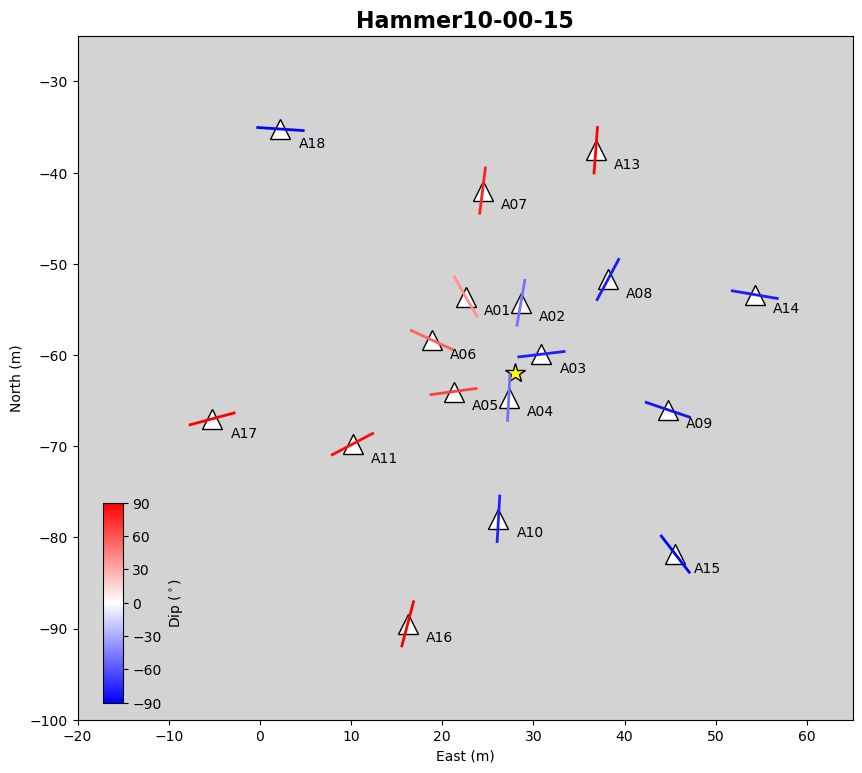

In [75]:
## Plot the dip and strike angles at each station and save the figure
source_coord = sourcedf[["east", "north"]].values[0]
fig, ax = plot_station_strike_and_dip(plotdf, source_coord, hammer)

fig.patch.set_alpha(0)
fig.savefig(join(root, timewin, f"stations_strike_and_dip_{hammer}.png"), dpi=300)